In [1]:
!pip install scikit-learn tensorflow matplotlib seaborn


In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


In [3]:
data_dir = 'G:/archive/PlantVillage'

class_names = sorted(os.listdir(data_dir))

# Create a DataFrame to hold file paths and labels
data = []
for class_name in class_names:
    class_dir = os.path.join(data_dir, class_name)
    for file in os.listdir(class_dir):
        data.append([os.path.join(class_dir, file), class_name])
data_df = pd.DataFrame(data, columns=['file_path', 'label'])

# Split the data
train_df, temp_df = train_test_split(data_df, test_size=0.3, stratify=data_df['label'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

print(f'Training samples: {len(train_df)}')
print(f'Validation samples: {len(val_df)}')
print(f'Test samples: {len(test_df)}')

Training samples: 4656
Validation samples: 998
Test samples: 998


In [4]:
# ImageDataGenerator for data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='file_path',
    y_col='label',
    target_size=(128, 128),
    batch_size=16,
    class_mode='categorical'
)

validation_generator = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col='file_path',
    y_col='label',
    target_size=(128, 128),
    batch_size=16,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col='file_path',
    y_col='label',
    target_size=(128, 128),
    batch_size=16,
    class_mode='categorical',
    shuffle=False
)


Found 4656 validated image filenames belonging to 6 classes.
Found 998 validated image filenames belonging to 6 classes.
Found 998 validated image filenames belonging to 6 classes.


In [5]:
# Load the ResNet50 model with pre-trained weights, excluding the top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = True

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(class_names), activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [6]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-8)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping, reduce_lr, checkpoint],
    verbose=1
)

Epoch 1/50
291/291 [==============================] - 54s 139ms/step - loss: 1.1271 - accuracy: 0.5805 - val_loss: 3.5293 - val_accuracy: 0.2883 - lr: 1.0000e-05
Epoch 2/50
291/291 [==============================] - 38s 130ms/step - loss: 0.5138 - accuracy: 0.8177 - val_loss: 3.8700 - val_accuracy: 0.2863 - lr: 1.0000e-05
Epoch 3/50
291/291 [==============================] - 39s 134ms/step - loss: 0.3496 - accuracy: 0.8729 - val_loss: 1.3521 - val_accuracy: 0.5706 - lr: 1.0000e-05
Epoch 4/50
291/291 [==============================] - 39s 134ms/step - loss: 0.2735 - accuracy: 0.9042 - val_loss: 0.2078 - val_accuracy: 0.9234 - lr: 1.0000e-05
Epoch 5/50
291/291 [==============================] - 40s 136ms/step - loss: 0.2170 - accuracy: 0.9205 - val_loss: 0.1123 - val_accuracy: 0.9607 - lr: 1.0000e-05
Epoch 6/50
291/291 [==============================] - 39s 134ms/step - loss: 0.1974 - accuracy: 0.9306 - val_loss: 0.1057 - val_accuracy: 0.9647 - lr: 1.0000e-05
Epoch 7/50
291/291 [========

In [7]:

# Load the best model
model = tf.keras.models.load_model('best_model.keras')

# Evaluate on test set
test_generator.reset()
preds = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
y_pred = np.argmax(preds, axis=1)
y_true = test_generator.classes

# Generate classification report
class_labels = list(test_generator.class_indices.keys())
report = classification_report(y_true, y_pred, target_names=class_labels)
print(report)

63/63 [==============================] - 4s 45ms/step
                       precision    recall  f1-score   support

Potato___Early_blight       0.99      1.00      0.99       150
 Potato___Late_blight       0.99      0.99      0.99       150
     Potato___healthy       1.00      1.00      1.00        23
  Tomato_Early_blight       0.99      0.98      0.99       150
   Tomato_Late_blight       0.99      0.99      0.99       287
       Tomato_healthy       1.00      1.00      1.00       238

             accuracy                           0.99       998
            macro avg       0.99      0.99      0.99       998
         weighted avg       0.99      0.99      0.99       998



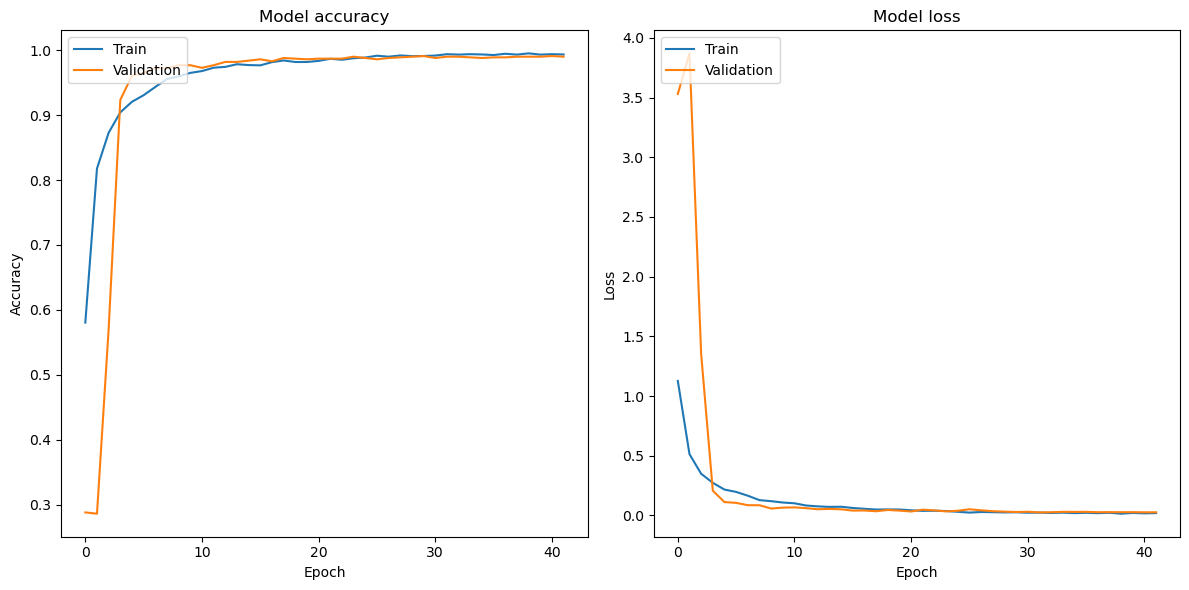

In [8]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [17]:
unique, counts = np.unique(y_pred, return_counts=True)
print(f"Predicted classes distribution: {dict(zip(unique, counts))}")


Predicted classes distribution: {0: 152, 1: 149, 2: 23, 3: 148, 4: 287, 5: 239}


In [10]:
model.save('ResNet99.keras')

In [12]:
val_loss, val_acc = model.evaluate(validation_generator)
print('Validation accuracy:', val_acc)

63/63 [==============================] - 3s 49ms/step - loss: 0.0256 - accuracy: 0.9900
Validation accuracy: 0.9899799823760986


In [37]:

model = tf.keras.models.load_model('ResNet99.keras')
try:
    test_generator.reset()
except AttributeError:
    print("Warning: test_generator does not have a reset() method. Proceeding without resetting.")


preds = model.predict(test_generator, steps=len(test_generator))


y_true = test_generator.classes
y_pred = np.argmax(preds, axis=1)


class_labels = list(test_generator.class_indices.keys())


report = classification_report(y_true, y_pred, target_names=class_labels)
print(report)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)


cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)

# Print confusion matrix using pandas DataFrame
print("\nConfusion Matrix:")
print(cm_df.to_markdown(numalign='left', stralign='left'))


63/63 [==============================] - 3s 37ms/step
                       precision    recall  f1-score   support

Potato___Early_blight       0.99      1.00      0.99       150
 Potato___Late_blight       0.99      0.99      0.99       150
     Potato___healthy       1.00      1.00      1.00        23
  Tomato_Early_blight       0.99      0.98      0.99       150
   Tomato_Late_blight       0.99      0.99      0.99       287
       Tomato_healthy       1.00      1.00      1.00       238

             accuracy                           0.99       998
            macro avg       0.99      0.99      0.99       998
         weighted avg       0.99      0.99      0.99       998


Confusion Matrix:
|                       | Potato___Early_blight   | Potato___Late_blight   | Potato___healthy   | Tomato_Early_blight   | Tomato_Late_blight   | Tomato_healthy   |
|:----------------------|:------------------------|:-----------------------|:-------------------|:----------------------|:--------